# Training of the flow matching model

In this script we will train the flow matching model.
For this purpose we will use the training data already encoded in a 50 dimension space.

- Loading libraries

In [1]:
from typing import Optional #, List, Type, Tuple, Dict
import math
import anndata as ad
from matplotlib import pyplot as plt
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- Loading data

In [2]:
# Load the encoded data from the autoencoder
data_dir = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/"
input_file_path = data_dir + "pbmc3k_train_with_latent.h5ad"
adata = ad.read_h5ad(input_file_path)

# Access latent representation
latent = adata.obsm["X_latent"]
# make it to a tensor and save in GPU
latent_tensor = torch.tensor(latent, dtype=torch.float32, device = device)
print("Shape of latent space:", latent.shape)
print(latent)

Shape of latent space: (2110, 50)
[[-1.4144031   1.3279299   0.757624   ...  1.9632016   3.2006185
   1.0286264 ]
 [-3.0197775  -1.5338613   1.2328798  ... -1.762154    3.0394304
  -0.13480194]
 [-2.9895246  -0.5492041   0.01084488 ...  1.2618108  -1.4493724
   0.35208455]
 ...
 [ 1.2099221   0.04875063 -0.70176685 ...  1.5337447   1.6093717
  -0.77522033]
 [ 0.16601333  0.13243417  1.3788003  ...  0.4668453  -1.8225284
   0.20945628]
 [-2.644291    0.13521816  0.795208   ... -0.2699267   1.9044281
  -2.3405967 ]]


### Defining the flow model classes

- **Alpha** and **beta** classes

We use $\alpha_t$ and $\beta_t$ to schedule the noise in the Gaussian probability paths.

These are two continuously differentiable, monotonic functions that follow:

$\alpha_0$ = $\beta_1$ = 0     and     $\alpha_1$ = $\beta_0$ = 1.

We have chosen a linear form with a simple derivative:

$\alpha_t$ = t ; $\alpha_t$' = 1

$\beta_t$ = 1 - t ; $\beta_t$' = -1


In [3]:
# We want to go with Gaussian probability path, therefore we need to load functions for alpha and beta
class LinearAlpha():
    """Implements alpha_t = t"""
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t  # linear in time

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)  # derivative of t is 1


class LinearBeta():
    """Implements beta_t = 1 - t"""
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return 1 - t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -torch.ones_like(t)  # derivative of 1 - t is -1



- **Gaussian probability path** class

In [4]:
class GaussianConditionalProbabilityPath():
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        alpha_t = self.alpha(t) # (num_samples, 1)
        beta_t = self.beta(t) # (num_samples, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
        - conditional_score: conditional score (num_samples, dim)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

- **Time** embedder

In [5]:
class TimeEmbedder(nn.Module):
    def __init__(self, embed_dim=64, max_freq=1e4):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_freq = max_freq
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim)
        )

    def forward(self, t):
        freqs = torch.exp(torch.linspace(0, math.log(self.max_freq), self.embed_dim // 2, device=t.device))
        args = t * freqs
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)

- **ResNetBlock** class

In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or dim*2
        self.block = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, dim),
            nn.LayerNorm(dim)
        )

    def forward(self, x):
        return x + self.block(x)

- **Neural vector field** class

In [11]:
class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, n_resblocks=5, time_embed_dim=64):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.time_embedder = TimeEmbedder(time_embed_dim)

        self.resblocks = nn.ModuleList([
            ResNetBlock(hidden_dim + time_embed_dim, hidden_dim*2) for _ in range(n_resblocks)
        ])
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim + time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, t):
        xh = self.x_proj(x)
        th = self.time_embedder(t)
        h = torch.cat([xh, th], dim=-1)
        for block in self.resblocks:
            h = block(h)
        return self.output_layer(h)

In [ ]:
class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim , hidden_dim=256, n_resblocks=5, time_embed_dim=64):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.z_proj = nn.Linear(latent_dim, hidden_dim)
        self.time_embedder = TimeEmbedder(time_embed_dim)

        self.resblocks = nn.ModuleList([
            ResNetBlock(hidden_dim*2 + time_embed_dim, hidden_dim*2) for _ in range(n_resblocks)
        ])
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim*2 + time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, z, t):
        xh = self.x_proj(x)
        zh = self.z_proj(z)
        th = self.time_embedder(t)
        h = torch.cat([xh, zh, th], dim=-1)
        for block in self.resblocks:
            h = block(h)
        return self.output_layer(h)


- Best **learned vector field**

In [17]:
# we want to save the best vector field:
class LearnedVectorFieldODE():
    def __init__(self, vf_model):
        self.vf_model = vf_model

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x, z: (batch_size, latent_dim)
        # t: (batch_size, 1)
        return self.vf_model(x, t)

## Hyperparameters and initialisation

- Hyperparameters

In [13]:
batch_size = 100
num_epochs = 5000
learning_rate = 1e-4

- Initialisation

In [14]:
alpha = LinearAlpha()
beta = LinearBeta()
latent_dim = latent_tensor.shape[1] # 50 in our case
vf_model = NeuralVectorField(latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(vf_model.parameters(), lr=learning_rate)
# Initialize GaussianConditionalProbabilityPath
path = GaussianConditionalProbabilityPath(alpha, beta)

## Training

In [15]:
epochs_list = []
loss_list = []
dataset = TensorDataset(latent_tensor) # just the latent vectors
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

for epoch in range(num_epochs):
    epoch_loss = 0.0 

    for batch in dataloader: 
        z = batch[0].to(device)                # minibatch of latent points 
        t = torch.rand(z.shape[0], 1, device=device)  # random time for each sample 
         
        # Sample x along conditional path 
        x = path.sample_conditional_path(z, t) 
         
        # Compute conditional vector field 
        cond_path = path.conditional_vector_field(x, z, t) 
     
        # Forward pass 
        #v_pred = vf_model(x, z, t) 
        v_pred = vf_model(x, t) 
         
        # Loss 
        loss = F.mse_loss(v_pred, cond_path) 
        epoch_loss += loss.item() * z.shape[0]  # accumulate total loss 
         
        # Backprop 
        optimizer.zero_grad() 
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(vf_model.parameters(), 1.0) 
        optimizer.step() 
     
    # Average loss over the full dataset 
    epoch_loss /= len(dataset) 
    epochs_list.append(epoch) 
    loss_list.append(epoch_loss) 
     
    if epoch % 50 == 0: 
        print(f"[{epoch}] Loss: {epoch_loss:.6f}") 
     

[0] Loss: 3.556863
[50] Loss: 2.600406
[100] Loss: 2.527398
[150] Loss: 2.466859
[200] Loss: 2.410509
[250] Loss: 2.386774
[300] Loss: 2.416086
[350] Loss: 2.332705
[400] Loss: 2.280647
[450] Loss: 2.221545
[500] Loss: 2.222754
[550] Loss: 2.187378
[600] Loss: 2.143483
[650] Loss: 2.105418
[700] Loss: 2.101544
[750] Loss: 2.028613
[800] Loss: 1.963352
[850] Loss: 1.996604
[900] Loss: 2.004411
[950] Loss: 1.962733
[1000] Loss: 1.938612
[1050] Loss: 1.862359
[1100] Loss: 1.853240
[1150] Loss: 1.862622
[1200] Loss: 1.869001
[1250] Loss: 1.846070
[1300] Loss: 1.824713
[1350] Loss: 1.807268
[1400] Loss: 1.797169
[1450] Loss: 1.751500
[1500] Loss: 1.741832
[1550] Loss: 1.795244
[1600] Loss: 1.723080
[1650] Loss: 1.726428
[1700] Loss: 1.701416
[1750] Loss: 1.701875
[1800] Loss: 1.685780
[1850] Loss: 1.683397
[1900] Loss: 1.626234
[1950] Loss: 1.619098
[2000] Loss: 1.613765
[2050] Loss: 1.622309
[2100] Loss: 1.644010
[2150] Loss: 1.634996
[2200] Loss: 1.590731
[2250] Loss: 1.600242
[2300] Loss

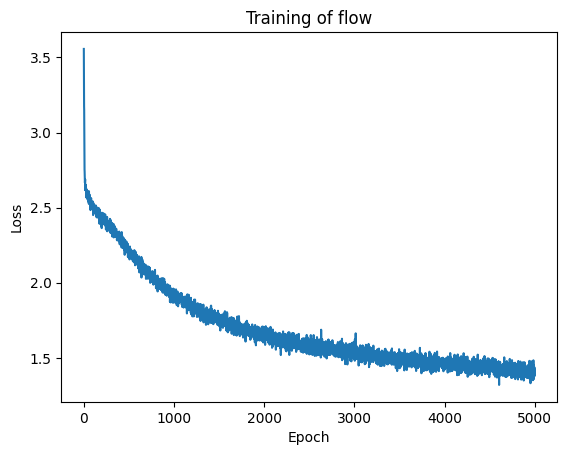

In [16]:
plt.plot(epochs_list, loss_list)
plt.title('Training of flow')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Saving files

In [18]:
save_path = data_dir + "vf_model_weights.pt"

torch.save(vf_model.state_dict(), save_path)

In [19]:
# Wrap the trained neural network
learned_ode = LearnedVectorFieldODE(vf_model)
save_path = data_dir + "learned_ode.pt"
# Save the wrapper
torch.save(learned_ode, save_path)